In [1]:
import os
import numpy as np
import tensorflow as tf
import pandas as pd
import datetime
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from PIL import Image
import itertools as iter
from random import shuffle

physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))


DATA_PATH = os.getenv('DATA_PATH')
print(DATA_PATH)


2023-08-26 16:06:44.592865: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-26 16:06:45.025790: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Num GPUs Available:  1
/mnt/e/ML/MonetGAN


2023-08-26 16:06:45.943303: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-26 16:06:45.961474: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-26 16:06:45.961803: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.


## Dataset

In [2]:
allFiles=[]
for root, dirs, files in os.walk(os.path.join(DATA_PATH, "processed")):
    for f in files:
        allFiles.append(os.path.join(root, f))

In [3]:
images=[]
for i,file in enumerate(tqdm(allFiles)):
    with Image.open(file) as im:
        images.append(np.array(im))

  0%|          | 0/1884 [00:00<?, ?it/s]

In [4]:
T=600
beta = np.linspace(1e-4, 0.03, T)
alpha = 1-beta
alphaBar = [np.prod(alpha[0:i+1]) for i,el in enumerate(alpha)]
IMAGE_SIZE = [256,256]
tValues = np.arange(0,T)
# alphaBar = np.cos((tValues/(T+1) + 0.008)/(1 + 0.008) * np.pi/2) 
# np.random.shuffle(tValues)



def forwardStep(x0Image,t):
    noise = np.random.normal(0, 1, x0Image.shape)
    noisy = np.sqrt(alphaBar[t])*x0Image + np.sqrt(1-alphaBar[t])*noise
    return noise, noisy


# Make a combination of all images and all possible t values and shuffle them
trainComb = [el for el in iter.product(np.arange(0,len(images)), tValues)]
shuffle(trainComb)
dataSize = len(trainComb)

#This generator provides all the timesteps for all images --> A huge dataset with comparably low variation
# def generator():
#     for fileIdx,tValue in trainComb:
#         # image = tf.io.read_file(file)
#         # image = tf.io.decode_jpeg(image, channels=3)
#         image = tf.convert_to_tensor(images[fileIdx])
#         image = tf.image.random_brightness(image, 0.1)
#         image = tf.image.random_contrast(image, 0.95, 1.05)
#         image = (tf.cast(image, tf.float32) / 127.5) - 1
#         x0 = image.numpy()
#         noise, noisy = forwardStep(x0, tValue)
#         yield noisy, noise, [tValue], x0

repeats=3
def generator():
    for im in images:
        # image = tf.io.read_file(file)
        # image = tf.io.decode_jpeg(image, channels=3)
        image = tf.convert_to_tensor(im)
        image = tf.image.random_brightness(image, 0.1)
        image = tf.image.random_contrast(image, 0.95, 1.05)
        image = (tf.cast(image, tf.float32) / 127.5) - 1
        x0 = image.numpy()
        for repeatIdx in range(repeats):
            tValue = np.random.randint(0,T)
            noise, noisy = forwardStep(x0, tValue)
            yield noisy, noise, [tValue], x0

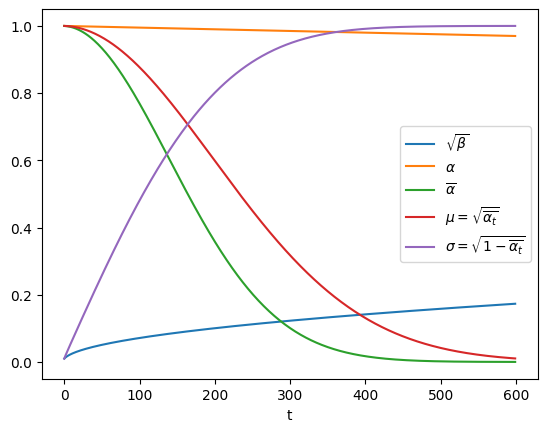

In [5]:
# _ = plt.plot(beta, label="beta")
_ = plt.plot(np.sqrt(beta), label=r"$\sqrt{\beta}$")
_ = plt.plot(alpha, label=r"$\alpha$")
_ = plt.plot(alphaBar, label=r"$\overline{\alpha}$")
_ = plt.plot(np.sqrt(alphaBar), label=r"$\mu = \sqrt{ \overline{\alpha_t} }$")
_ = plt.plot(np.sqrt(1-np.array(alphaBar)[np.arange(0,T)]), label=r"$\sigma = \sqrt{ 1-\overline{\alpha_t} }$")
_ = plt.legend()
_ = plt.xlabel("t")

In [6]:
def postprocessImage(im):
    return np.clip(im/2+0.5,0,1)

In [7]:
g = generator()
test = next(g)
print(test[2])
print(test[0].shape)
print(test[1].shape)

2023-08-26 16:06:50.584567: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-26 16:06:50.585010: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-26 16:06:50.586188: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-26 16:06:51.063946: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-26 16:06:51.064283: I tensorflow/compile

[151]
(256, 256, 3)
(256, 256, 3)


mmon_runtime/gpu/gpu_device.cc:1726] Could not identify NUMA node of platform GPU id 0, defaulting to 0.  Your kernel may not have been built with NUMA support.
2023-08-26 16:06:51.064597: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-26 16:06:51.064631: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6595 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1070, pci bus id: 0000:2b:00.0, compute capability: 6.1


In [8]:
test = next(g)
np.max(test[0])

4.195950279252784

Text(0.5, 1.0, 'Noise')

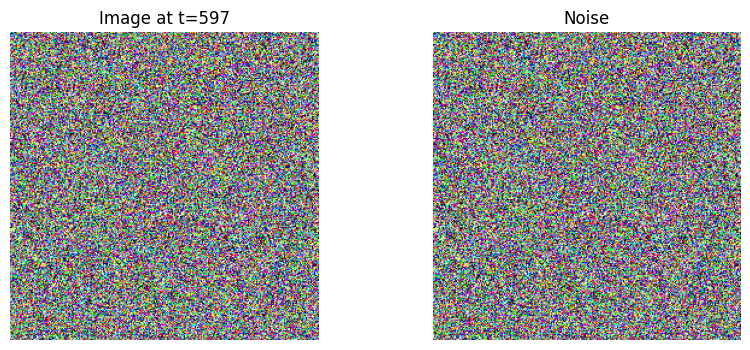

In [9]:
test = next(g)
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(postprocessImage(test[0]))
plt.axis('off')
plt.title("Image at t="+str(test[2][0]))
plt.subplot(1,2,2)
plt.imshow(postprocessImage(test[1]))
plt.axis('off')
plt.title("Noise")

## Testing of the forward and backward process

Test the denoising steps all at one (what the neural network should predict gradually)

(-0.5, 255.5, 255.5, -0.5)

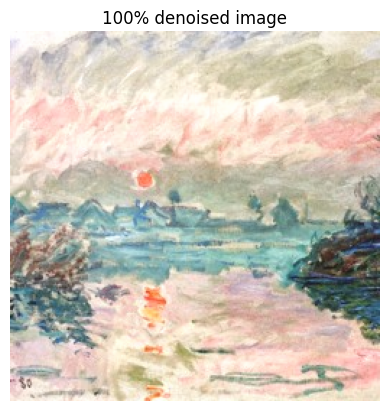

In [10]:
testDenoised = (test[0] - np.sqrt(1-alphaBar[test[2][0]])*test[1])/np.sqrt(alphaBar[test[2][0]])
plt.imshow((testDenoised+1)/2)
plt.title("100% denoised image")
plt.axis('off')

Forward pass

In [11]:
noisyImages=[]
noises=[]
x0=images[0]/127.5-1
for tStep in range(T):
    noise, noisy = forwardStep(x0, tStep)
    noisyImages.append(noisy)
    noises.append(noise)

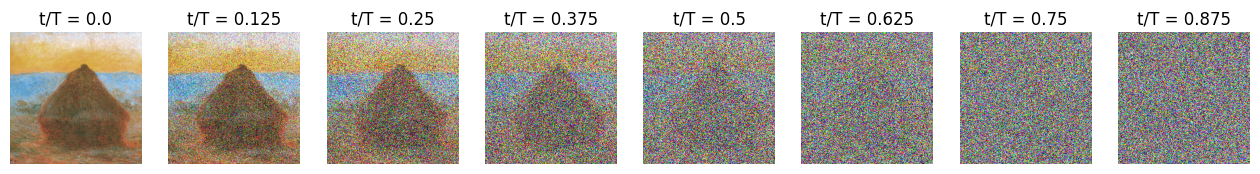

In [12]:
plt.figure(figsize=(16,5))
for i in range(8):
    plt.subplot(1,8,i+1)
    plt.imshow(postprocessImage(noisyImages[int(i*T/8)]))
    plt.axis("off")
    plt.title("t/T = "+str(i/8))

Backward pass

In [13]:
samples = [noisyImages[-1]]
predNoises = [noises[-1]]

def backwardStep(xt, t, predNoise=None, x0Pred=None):

    if x0Pred is None:
        x0Pred=(xt - np.sqrt(1-alphaBar[t])*predNoise)/np.sqrt(alphaBar[t])

    if t==0:
        sample = x0Pred
        noise= np.zeros(xt.shape)
    else:
        # estimate mean
        meanPred= x0Pred * (np.sqrt(alphaBar[t])*beta[t])/((1-alphaBar[t])*np.sqrt(alpha[t])) + xt*(alpha[t]-alphaBar[t])/((1-alphaBar[t])*np.sqrt(alpha[t]))

        # compute variance
        betaPred = np.sqrt(beta[t])

        sample = meanPred + betaPred*np.random.normal(0,1,xt.shape)

        noise=(sample-x0Pred*np.sqrt(alphaBar[t-1]))/np.sqrt(1-alphaBar[t-1])

    return sample, noise

for t in np.arange(0,T)[::-1]:
    predNoise = predNoises[-1]
    xt = samples[-1]

    sample, noise = backwardStep(xt, t, predNoise=predNoise)
    # sample, noise = backwardStep(xt, t, x0Pred=noisyImages[0])

    samples.append(sample)
    predNoises.append(noise)

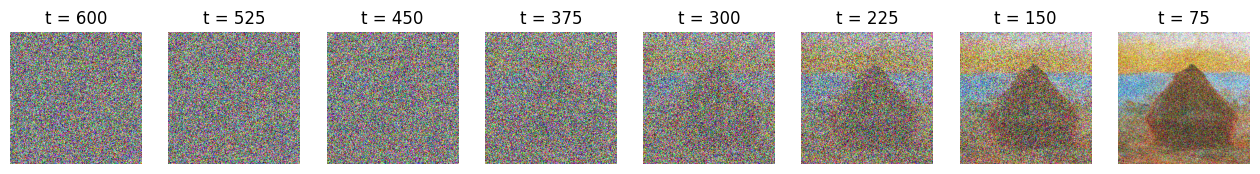

In [14]:
plt.figure(figsize=(16,5))
for i in range(8):
    plt.subplot(1,8,i+1)
    plt.imshow(postprocessImage(samples[int(i*T/8)]))
    plt.axis("off")
    plt.title("t = "+str(int(T-i*T/8)))

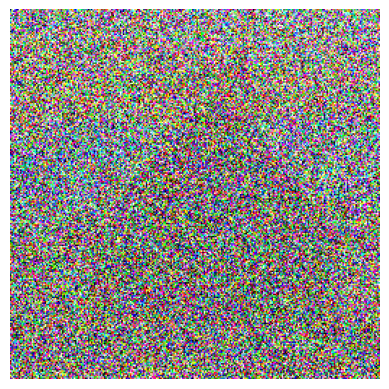

In [15]:
dataset = tf.data.Dataset.from_generator(generator, output_signature=(tf.TensorSpec(shape=(*IMAGE_SIZE, 3), dtype=tf.float32),
                            tf.TensorSpec(shape=(*IMAGE_SIZE, 3), dtype=tf.float32),
                            tf.TensorSpec(shape=(1), dtype=tf.int32),
                            tf.TensorSpec(shape=(*IMAGE_SIZE, 3), dtype=tf.float32)))
_ = plt.imshow(np.clip(list(dataset.take(20))[1][0].numpy()/2+0.5, 0,1))
_ = plt.axis("off")

## Tensorflow

In [16]:
%load_ext tensorboard


In [17]:

def createSimpleUnet():
    inputs = tf.keras.Input(shape=(*IMAGE_SIZE, 3))
    #256

    stepInput = tf.keras.Input(shape=(1,), dtype=tf.int32)
    embeddedStep = tf.keras.layers.Embedding(T, 256)(stepInput)
    stepMap = tf.repeat(embeddedStep, 256, axis=0)
    stepMap = tf.reshape(stepMap, (-1,*IMAGE_SIZE, 1))

    concatInput = tf.keras.layers.Concatenate()([inputs, stepMap])

    xDown1In = tf.keras.layers.Conv2D(8, 3, padding="same", activation="relu" )(concatInput)
    xDown1 = tf.keras.layers.Conv2D(16, 3, padding="same", strides=2, activation="relu"  )(xDown1In)
    xDown1 = tf.keras.layers.Conv2D(16, 3, padding="same", activation="relu"  )(xDown1)
    #128
    
    xDown2 = tf.keras.layers.Conv2D(16, 3, padding="same", activation="relu" )(xDown1)
    xDown2 = tf.keras.layers.Conv2D(32, 3, padding="same", strides=2, activation="relu")(xDown2)
    xDown2 = tf.keras.layers.Conv2D(32, 3, padding="same", activation="relu" )(xDown2)
    #64

    xDown3 = tf.keras.layers.Conv2D(32, 3, padding="same", activation="relu" )(xDown2)
    xDown3 = tf.keras.layers.Conv2D(64, 3, padding="same", strides=2, activation="relu"  )(xDown3)
    xDown3 = tf.keras.layers.Conv2D(64, 3, padding="same", activation="relu"  )(xDown3)
    #32

    xCenter = tf.keras.layers.Conv2D(64, 3, padding="same" )(xDown3)

    stepMap16 = tf.keras.layers.Conv2D(3, 3, strides=8, padding="same")(stepMap)
    concatCenter = tf.keras.layers.Concatenate()([xCenter, stepMap16])

    xCenter = tf.keras.layers.Conv2D(64, 3, padding="same", activation="relu")(concatCenter)
    #32x32


    xUp3 = tf.keras.layers.Conv2D(64, 3, padding="same", activation="relu")(xCenter)
    xConcat3 = tf.keras.layers.Concatenate()([xUp3, xDown3])
    xUp3 = tf.keras.layers.Conv2D(64, 3, padding="same", activation="relu" )(xConcat3)
    xUp3 = tf.keras.layers.Conv2DTranspose(32, 3, padding="same", strides=2, activation="relu")(xUp3)
    xUp3 = tf.keras.layers.Conv2D(32, 3, padding="same", activation="relu" )(xUp3)
    #64x64

    xUp2 = tf.keras.layers.Conv2D(32, 3, padding="same", activation="relu")(xUp3)
    xConcat2 = tf.keras.layers.Concatenate()([xUp2, xDown2])
    xUp2 = tf.keras.layers.Conv2D(32, 3, padding="same", activation="relu" )(xConcat2)
    xUp2 = tf.keras.layers.Conv2DTranspose(16, 3, padding="same", strides=2, activation="relu")(xUp2)
    xUp2 = tf.keras.layers.Conv2D(16, 3, padding="same", activation="relu" )(xUp2)
    #128x128

    xUp1 = tf.keras.layers.Conv2D(16, 3, padding="same", activation="relu")(xUp2)
    xConcat1 = tf.keras.layers.Concatenate()([xUp1, xDown1])
    xUp1 = tf.keras.layers.Conv2D(16, 3, padding="same", activation="relu" )(xConcat1)
    xUp1 = tf.keras.layers.Conv2DTranspose(8, 3, padding="same", strides=2, activation="relu")(xUp1)
    xUp1 = tf.keras.layers.Conv2D(8, 3, padding="same", activation="relu" )(xUp1)
    #256x256

    xConcat = tf.keras.layers.Concatenate()([xUp1, xDown1In])
    x = tf.keras.layers.Conv2D(8, 3, padding="same", activation="relu" )(xConcat)
    
    x=tf.keras.layers.Conv2D(8, 3, padding="same", activation="relu")(xUp1)

    outputs=tf.keras.layers.Conv2D(3, 1, padding="same")(x)

    return tf.keras.Model(inputs=[inputs,stepInput], outputs=outputs, name="SimpleUnet")


# model = createSimpleUnet()

# model.summary()

# dot_img_file = './'+model.name +'.png'
# tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)


Model: "unet_T600_K2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 embedding (Embedding)       (None, 1, 256)               153600    ['input_2[0][0]']             
                                                                                                  
 tf.repeat (TFOpLambda)      (None, 1, 256)               0         ['embedding[0][0]']           
                                                                                                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                       

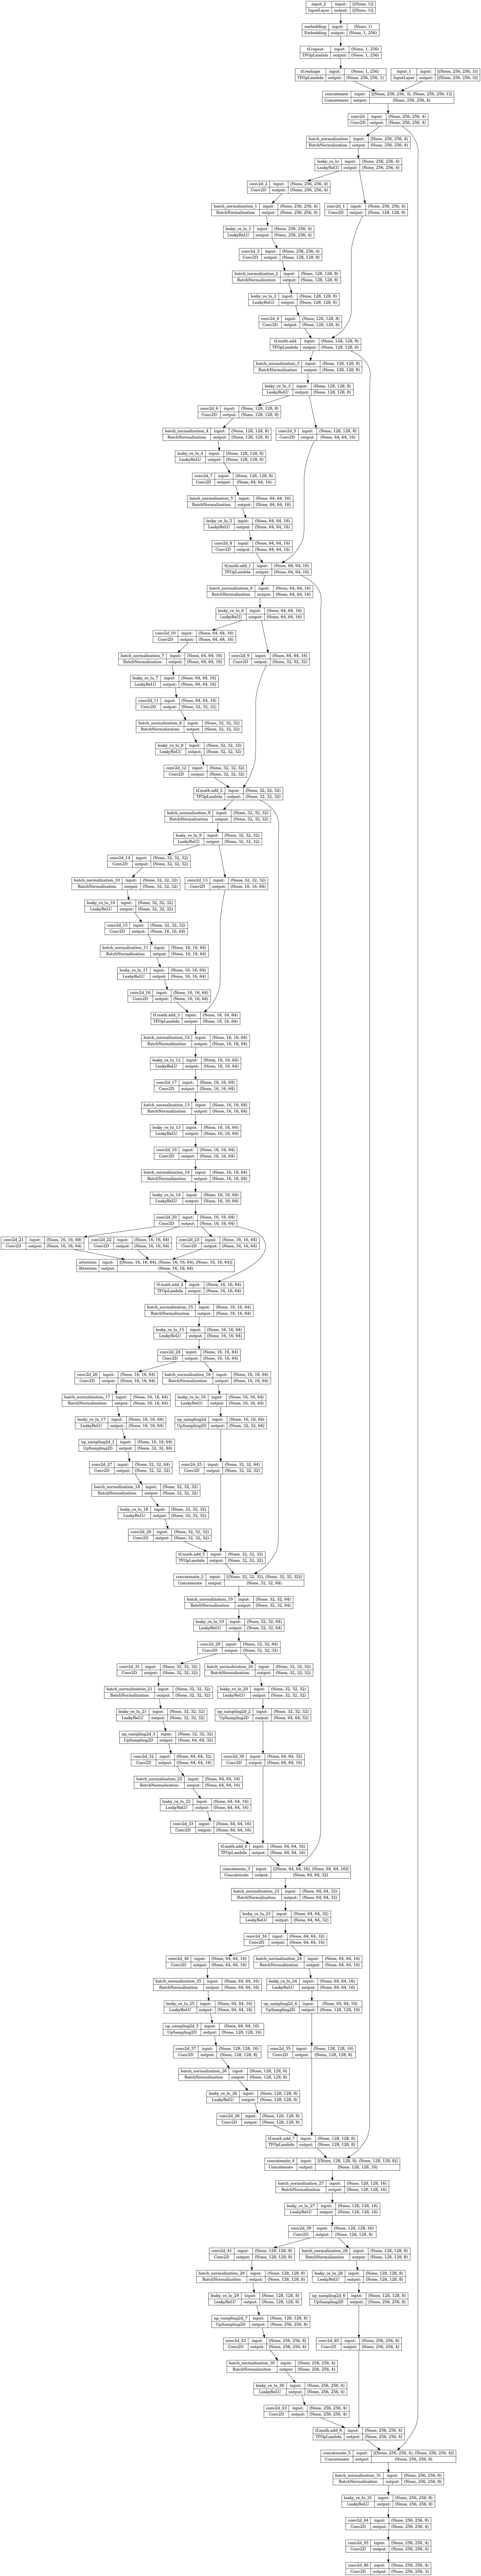

In [18]:
L2=0

def downscaleBlock(xIn, chBefore, chAfter, filtersize):
    x = tf.keras.layers.BatchNormalization()(xIn)
    x = tf.keras.layers.LeakyReLU()(x)

    # xRes = tf.keras.layers.AveragePooling2D((3,3), strides=2, padding="same")(x)
    xRes = tf.keras.layers.Conv2D(chAfter, 1, strides=2, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(x)

    x = tf.keras.layers.Conv2D(chBefore, filtersize, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(x)
    
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)
    # x = tf.keras.layers.AveragePooling2D((3,3), strides=2, padding="same")(x)
    x = tf.keras.layers.Conv2D(chAfter, filtersize, strides=2, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(x)

    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Conv2D(chAfter, filtersize, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(x)

    added = tf.math.add(x, xRes)
    
    return added


def upscaleBlock(xIn, chBefore, chAfter, filtersize):
    x = tf.keras.layers.BatchNormalization()(xIn)
    x = tf.keras.layers.LeakyReLU()(x)

    xRes = tf.keras.layers.UpSampling2D(size=(2, 2))(x)
    # xRes = tf.keras.layers.Conv2DTranspose(chAfter, filtersize, strides=2, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(xIn)
    xRes = tf.keras.layers.Conv2D(chAfter, 1, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=0.01))(xRes)

    x = tf.keras.layers.Conv2D(chBefore, filtersize, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(xIn)
    
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.UpSampling2D(size=(2, 2))(x)
    x = tf.keras.layers.Conv2D(chAfter, filtersize, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(x)
    # x = tf.keras.layers.Conv2DTranspose(chAfter, filtersize, strides=2, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(x)

    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Conv2D(chAfter, filtersize, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(x)

    added = tf.math.add(x, xRes)

    return added


def nonLocalBlock(xIn, ch, filtersize=1):
    theta = tf.keras.layers.Conv2D(ch, filtersize, padding="same")(xIn)
    phi = tf.keras.layers.Conv2D(ch, filtersize, padding="same")(xIn)
    g = tf.keras.layers.Conv2D(ch, filtersize, padding="same")(xIn)
    out = tf.keras.layers.Attention()([theta, phi, g])
    return tf.math.add(xIn, out)


def centerBlock(xIn, stepMap, ch, filtersize):
    x = tf.keras.layers.BatchNormalization()(xIn)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Conv2D(ch, filtersize, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(x)

    stepMap16 = tf.keras.layers.Conv2D(3, filtersize, strides=16, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(stepMap)
    concatCenter = tf.keras.layers.Concatenate()([x, stepMap16])

    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Conv2D(ch, filtersize, dilation_rate=2, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(x)

    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Conv2D(ch, filtersize, dilation_rate=4, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(x)

    x = nonLocalBlock(x, ch)

    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Conv2D(ch, filtersize, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(x)

    return x

def createUnet(K=2):
    inputs = tf.keras.Input(shape=(*IMAGE_SIZE, 3))
    #256

    stepInput = tf.keras.Input(shape=(1,), dtype=tf.int32)
    embeddedStep = tf.keras.layers.Embedding(T, 256)(stepInput)
    stepMap = tf.repeat(embeddedStep, 256, axis=0)
    stepMap = tf.reshape(stepMap, (-1,*IMAGE_SIZE, 1))

    concatInput = tf.keras.layers.Concatenate()([inputs, stepMap])

    xDown2 = tf.keras.layers.Conv2D(K*2, 3, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(concatInput)
    
    xDown4 = downscaleBlock(xDown2, K*2, K*4, 3)
    #128

    xDown8 = downscaleBlock(xDown4, K*4, K*8, 3)
    #64

    xDown16 = downscaleBlock(xDown8, K*8, K*16, 3)
    #32

    xDown32 = downscaleBlock(xDown16, K*16, K*32, 3)
    #16x16

    xCenter = centerBlock(xDown32, stepMap, K*32, 3)
    #16x16

    xUp16 = upscaleBlock(xCenter, K*32, K*16, 3)
    #32x32
    xConcat16 = tf.keras.layers.Concatenate()([xUp16, xDown16])
    xUp16 = tf.keras.layers.BatchNormalization()(xConcat16)
    xUp16 = tf.keras.layers.LeakyReLU()(xUp16)
    xUp16=tf.keras.layers.Conv2D(K*16, 3, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(xUp16)

    xUp8 = upscaleBlock(xUp16, K*16, K*8, 3)
    #64
    xConcat8 = tf.keras.layers.Concatenate()([xDown8, xUp8])
    xUp8 = tf.keras.layers.BatchNormalization()(xConcat8)
    xUp8 = tf.keras.layers.LeakyReLU()(xUp8)
    xUp8=tf.keras.layers.Conv2D(K*8, 3, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(xUp8)

    xUp4 = upscaleBlock(xUp8, K*8, K*4, 3)
    #128
    xConcat4 = tf.keras.layers.Concatenate()([xDown4, xUp4])
    xUp4 = tf.keras.layers.BatchNormalization()(xConcat4)
    xUp4 = tf.keras.layers.LeakyReLU()(xUp4)
    xUp4=tf.keras.layers.Conv2D(K*4, 3, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(xUp4)

    xUp2 = upscaleBlock(xUp4, K*4, K*2, 3)
    #256
    xConcat2 = tf.keras.layers.Concatenate()([xDown2, xUp2])
    
    x = tf.keras.layers.BatchNormalization()(xConcat2)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Conv2D(K*2, 3, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(x)

    x = tf.keras.layers.Conv2D(K*2, 3, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(x)

    outputs=tf.keras.layers.Conv2D(3, 1, padding="same")(x)

    return tf.keras.Model(inputs=[inputs,stepInput], outputs=outputs, name="unet_T{}_K{}".format(T,K))


model = createUnet()

model.summary()

dot_img_file = './'+model.name +'.png'
tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)


In [19]:
loadExistingModel=False

if loadExistingModel:
    model = tf.keras.models.load_model(os.path.join(DATA_PATH, "diffusionModel_epoch_0"))
    startEpoch=1
else:
    startEpoch=0

In [20]:
def saveImages(model, epoch, step, summary_writer=None, maxStep=0):
  initInput = tf.random.normal((3, *IMAGE_SIZE, 3), dtype=tf.float32)
  samples = [initInput]

  for t in np.arange(0,T)[::-1]:
      pred = model((samples[-1], tf.constant([t, t, t])), training=False)
      xt = samples[-1]
      
      # sample, noise = backwardStep(xt, t, x0Pred=predX0)
      sample, noise = backwardStep(xt, t, predNoise=pred)

      samples.append(sample)

  _ = plt.figure(figsize=(12,8))

  sampleIdx = np.linspace(0, T, 5)

  for j in range(3):
    for i in range(5):
        _ = plt.subplot(3, 5, j*5+i+1)
        plt.imshow(postprocessImage(samples[int(sampleIdx[i])])[j,:,:,:])
        if summary_writer is not None:
           with summary_writer.as_default():
              tf.summary.image("Training data", postprocessImage(samples[int(sampleIdx[-1])]), step=maxStep*epoch+step)
        plt.axis("off")
        plt.title("Step {}".format(T-int(sampleIdx[i])))

  plt.savefig(os.path.join(DATA_PATH,"trainImagesDiffusion", 'epoch_{:04d}_step_{:04d}.png'.format(epoch, step)))
  plt.close()

In [21]:
class MSESSIMLoss(tf.keras.losses.Loss):
    def __init__(self, alpha):
        super().__init__(name="MSE_SSIM_Loss")
        assert(alpha<1.0)
        self.alpha = tf.constant(alpha)
        
    def call(self, yTrue, yPred):
        mse =  tf.math.reduce_mean(tf.math.square(yPred - yTrue))
        ssim = tf.image.ssim(tf.clip_by_value(yPred,-1,1)/2+0.5, tf.clip_by_value(yTrue,-1,1)/2+0.5, max_val=1.0)
        ssimLoss =  1-tf.math.reduce_mean(ssim, axis=-1)
        return (1-self.alpha)*mse + self.alpha*ssimLoss

testLoss = MSESSIMLoss(0.2)
testLoss(tf.ones([1,20,20,3]), tf.ones([1,20,20,3])*0.9)

<tf.Tensor: shape=(), dtype=float32, numpy=0.0084743025>

In [22]:

BATCH_SIZE=64
LOG_INTERVAL=5
SAVE_IMAGE_INTERVAL=20
epochs = 50
saveModel=True



log_dir = "./logs/"+model.name+"/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1,
                                                      write_graph=True, update_freq=5)


summary_writer = tf.summary.create_file_writer(log_dir)

# Instantiate an optimizer .
# optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule)
# optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3)
optimizer = tf.keras.optimizers.Adam(learning_rate=6e-4)

# Instantiate a loss function.
# lossFn = tf.keras.losses.MeanAbsoluteError()
lossFn = tf.keras.losses.MeanSquaredError()
# lossFn = MSESSIMLoss(0.1)


# batchedDataset = datasetMonet.batch(BATCH_SIZE, drop_remainder=False)
# datasetShuffled = dataset.shuffle(200)
batchedDataset = dataset.batch(BATCH_SIZE, drop_remainder=False).prefetch(tf.data.AUTOTUNE)



@tf.function()
def trainStep(noisyImage, noise, t):
    with tf.GradientTape() as tape:
        predicted = model((noisyImage, t), training=True) 

        loss = lossFn(predicted, noise)


    grads = tape.gradient(loss, model.trainable_weights)

    optimizer.apply_gradients(zip(grads, model.trainable_weights)) 

    return loss, predicted



maxStep=len(allFiles)*T//BATCH_SIZE


for epoch in np.arange(startEpoch, startEpoch+epochs, 1):
    print("\nStart of epoch %d" % (epoch,))

    # Iterate over the batches of the dataset.
    for step, (noisyImage, noise, t, x0) in enumerate(batchedDataset):
        loss, predictedImage = trainStep(noisyImage, noise, t)

        # Log 
        if step % LOG_INTERVAL == 0:
            ssim = tf.image.ssim(postprocessImage(predictedImage), postprocessImage(noise), max_val=1.0)
            template = 'Epoch {}/Step {}, Loss: {:.4f}, SSIM: {:.4f}'
            print(template.format(epoch, step, loss.numpy(), tf.math.reduce_mean(ssim).numpy()))
            
            with summary_writer.as_default():
                tf.summary.scalar('loss', loss, step=maxStep*epoch+step)
                tf.summary.scalar('ssim', tf.math.reduce_mean(ssim), step=maxStep*epoch+step)
                summary_writer.flush()
        
        if step % SAVE_IMAGE_INTERVAL==0:
            saveImages(model, epoch, step, summary_writer, maxStep)

    maxStep=step

    if saveModel:
      model.save(os.path.join(DATA_PATH, model.name+"epoch_{}".format(epoch)))

print("done")


Start of epoch 0


2023-08-26 16:08:38.034151: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-08-26 16:08:40.340652: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f0ef9fcfc60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-08-26 16:08:40.340691: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1070, Compute Capability 6.1
2023-08-26 16:08:40.344279: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-08-26 16:08:40.426256: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Epoch 0/Step 0, Loss: 1.5655, SSIM: -0.0054
Epoch 0/Step 10, Loss: 1.2194, SSIM: 0.0458
Epoch 0/Step 20, Loss: 1.0860, SSIM: 0.1043
Epoch 0/Step 30, Loss: 1.0027, SSIM: 0.1635
Epoch 0/Step 40, Loss: 0.9463, SSIM: 0.2083


/home/manuel/miniconda3/envs/tf/lib/python3.9/site-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


Epoch 0/Step 50, Loss: 0.8976, SSIM: 0.2548
INFO:tensorflow:Assets written to: /mnt/e/ML/MonetGAN/unet_T600_K2epoch_0/assets


INFO:tensorflow:Assets written to: /mnt/e/ML/MonetGAN/unet_T600_K2epoch_0/assets



Start of epoch 1
Epoch 1/Step 0, Loss: 0.8467, SSIM: 0.3135
Epoch 1/Step 10, Loss: 0.8168, SSIM: 0.3433
Epoch 1/Step 20, Loss: 0.7859, SSIM: 0.3778
Epoch 1/Step 30, Loss: 0.7528, SSIM: 0.4150
Epoch 1/Step 40, Loss: 0.7290, SSIM: 0.4405
Epoch 1/Step 50, Loss: 0.7227, SSIM: 0.4419


INFO:tensorflow:Assets written to: /mnt/e/ML/MonetGAN/unet_T600_K2epoch_1/assets


INFO:tensorflow:Assets written to: /mnt/e/ML/MonetGAN/unet_T600_K2epoch_1/assets



Start of epoch 2
Epoch 2/Step 0, Loss: 0.6939, SSIM: 0.4719
Epoch 2/Step 10, Loss: 0.7113, SSIM: 0.4466
Epoch 2/Step 20, Loss: 0.6496, SSIM: 0.5206
Epoch 2/Step 30, Loss: 0.6382, SSIM: 0.5271
Epoch 2/Step 40, Loss: 0.6365, SSIM: 0.5244
Epoch 2/Step 50, Loss: 0.6152, SSIM: 0.5462


INFO:tensorflow:Assets written to: /mnt/e/ML/MonetGAN/unet_T600_K2epoch_2/assets


INFO:tensorflow:Assets written to: /mnt/e/ML/MonetGAN/unet_T600_K2epoch_2/assets



Start of epoch 3
Epoch 3/Step 0, Loss: 0.5919, SSIM: 0.5695
Epoch 3/Step 10, Loss: 0.6007, SSIM: 0.5522
Epoch 3/Step 20, Loss: 0.5853, SSIM: 0.5682
Epoch 3/Step 30, Loss: 0.5708, SSIM: 0.5818
Epoch 3/Step 40, Loss: 0.5256, SSIM: 0.6284
Epoch 3/Step 50, Loss: 0.5231, SSIM: 0.6307


INFO:tensorflow:Assets written to: /mnt/e/ML/MonetGAN/unet_T600_K2epoch_3/assets


INFO:tensorflow:Assets written to: /mnt/e/ML/MonetGAN/unet_T600_K2epoch_3/assets



Start of epoch 4
Epoch 4/Step 0, Loss: 0.5160, SSIM: 0.6338
Epoch 4/Step 10, Loss: 0.5355, SSIM: 0.6079
Epoch 4/Step 20, Loss: 0.4720, SSIM: 0.6764
Epoch 4/Step 30, Loss: 0.5132, SSIM: 0.6239
Epoch 4/Step 40, Loss: 0.4630, SSIM: 0.6782
Epoch 4/Step 50, Loss: 0.4523, SSIM: 0.6878


INFO:tensorflow:Assets written to: /mnt/e/ML/MonetGAN/unet_T600_K2epoch_4/assets


INFO:tensorflow:Assets written to: /mnt/e/ML/MonetGAN/unet_T600_K2epoch_4/assets



Start of epoch 5
Epoch 5/Step 0, Loss: 0.4282, SSIM: 0.7039
Epoch 5/Step 10, Loss: 0.4348, SSIM: 0.6930
Epoch 5/Step 20, Loss: 0.4165, SSIM: 0.7164
Epoch 5/Step 30, Loss: 0.4132, SSIM: 0.7174
Epoch 5/Step 40, Loss: 0.3985, SSIM: 0.7230
Epoch 5/Step 50, Loss: 0.3767, SSIM: 0.7411


INFO:tensorflow:Assets written to: /mnt/e/ML/MonetGAN/unet_T600_K2epoch_5/assets


INFO:tensorflow:Assets written to: /mnt/e/ML/MonetGAN/unet_T600_K2epoch_5/assets



Start of epoch 6
Epoch 6/Step 0, Loss: 0.3992, SSIM: 0.7150
Epoch 6/Step 10, Loss: 0.3510, SSIM: 0.7644
Epoch 6/Step 20, Loss: 0.3778, SSIM: 0.7357
Epoch 6/Step 30, Loss: 0.3068, SSIM: 0.7987
Epoch 6/Step 40, Loss: 0.3417, SSIM: 0.7677
Epoch 6/Step 50, Loss: 0.3042, SSIM: 0.7987


INFO:tensorflow:Assets written to: /mnt/e/ML/MonetGAN/unet_T600_K2epoch_6/assets


INFO:tensorflow:Assets written to: /mnt/e/ML/MonetGAN/unet_T600_K2epoch_6/assets



Start of epoch 7
Epoch 7/Step 0, Loss: 0.2950, SSIM: 0.8058
Epoch 7/Step 10, Loss: 0.2761, SSIM: 0.8180
Epoch 7/Step 20, Loss: 0.3087, SSIM: 0.7878
Epoch 7/Step 30, Loss: 0.3122, SSIM: 0.7838
Epoch 7/Step 40, Loss: 0.2420, SSIM: 0.8425
Epoch 7/Step 50, Loss: 0.2972, SSIM: 0.7949


INFO:tensorflow:Assets written to: /mnt/e/ML/MonetGAN/unet_T600_K2epoch_7/assets


INFO:tensorflow:Assets written to: /mnt/e/ML/MonetGAN/unet_T600_K2epoch_7/assets



Start of epoch 8
Epoch 8/Step 0, Loss: 0.2315, SSIM: 0.8550
Epoch 8/Step 10, Loss: 0.2203, SSIM: 0.8582
Epoch 8/Step 20, Loss: 0.2370, SSIM: 0.8461
Epoch 8/Step 30, Loss: 0.2310, SSIM: 0.8541
Epoch 8/Step 40, Loss: 0.2528, SSIM: 0.8317
Epoch 8/Step 50, Loss: 0.2230, SSIM: 0.8564


INFO:tensorflow:Assets written to: /mnt/e/ML/MonetGAN/unet_T600_K2epoch_8/assets


INFO:tensorflow:Assets written to: /mnt/e/ML/MonetGAN/unet_T600_K2epoch_8/assets



Start of epoch 9
Epoch 9/Step 0, Loss: 0.2606, SSIM: 0.8313
Epoch 9/Step 10, Loss: 0.2277, SSIM: 0.8506
Epoch 9/Step 20, Loss: 0.2289, SSIM: 0.8476
Epoch 9/Step 30, Loss: 0.2248, SSIM: 0.8518
Epoch 9/Step 40, Loss: 0.1779, SSIM: 0.8896
Epoch 9/Step 50, Loss: 0.2510, SSIM: 0.8245


INFO:tensorflow:Assets written to: /mnt/e/ML/MonetGAN/unet_T600_K2epoch_9/assets


INFO:tensorflow:Assets written to: /mnt/e/ML/MonetGAN/unet_T600_K2epoch_9/assets


done


In [ ]:
initInput = tf.random.normal((2, *IMAGE_SIZE, 3), dtype=tf.float32)
samples = [initInput]

for t in np.arange(0,T)[::-1]:
    predNoise = model((samples[-1], tf.constant([t,t])))
    xt = samples[-1]
    
    sample, noise = backwardStep(xt, predNoise, t)

    samples.append(sample)

_ = plt.figure(figsize=(12,5))

sampleIdx = np.linspace(0, T, 5)

for j in range(2):
    for i in range(5):
        _ = plt.subplot(2,5,j*5+i+1)
        plt.imshow(np.clip((samples[int(sampleIdx[i])].numpy()[j,:,:,:]+1)/2, 0, 1))
        plt.axis("off")
        plt.title("Step {}".format(T-int(sampleIdx[i])))

In [ ]:
testImage=tf.expand_dims(list(dataset.take(50))[34][0],0)
testT=tf.expand_dims(list(dataset.take(50))[34][2],0)
testNoise=tf.expand_dims(list(dataset.take(50))[34][1],0)

In [ ]:
predNoise = model((testImage, testT))
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.imshow((predNoise.numpy()[0,:,:,:]+1)/2)
plt.title("Predicted Noise")
plt.subplot(1,2,2)
plt.title("Real Noise")
plt.imshow((testNoise.numpy()[0,:,:,:]+1)/2)

In [ ]:
testTNum = testT.numpy()[0][0]

In [ ]:
denoised = (testImage - (1-alpha[testTNum])/np.sqrt(1-alphaBar[testTNum])*predNoise)/np.sqrt(alpha[testTNum])
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.imshow((testImage.numpy()[0,:,:,:]+1)/2)
plt.title("Original Image")
plt.subplot(1,2,2)
plt.title("Denoised Image by 1 step")
plt.imshow((denoised.numpy()[0,:,:,:]+1)/2)